In [16]:
!pip install --user tensorflow_hub


  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl (30 kB)
  Using cached tf_keras-2.16.0-py3-none-any.whl (1.7 MB)
  Using cached tensorflow-2.16.2-cp311-cp311-win_amd64.whl (2.1 kB)


In [1]:
from flask import Flask, request, jsonify
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import base64

In [2]:
app = Flask(__name__)

In [19]:
import sys
print(sys.executable)


C:\Users\Manya\anaconda3\python.exe


Loading MobileNetV2 model from TensorFlow Hub...
Model loaded successfully.
Classifying test data and displaying images...
Processing image at index 0. Description: KALINI Ethnic Motif Woven Design Zari Banarasi Saree
is_men: False, is_women: False
Processed image at index 0. Predicted category: grace_sarees
Processing image at index 1. Description: Sangria Paisley Printed Saree
is_men: False, is_women: False
Processed image at index 1. Predicted category: grace_sarees
Processing image at index 2. Description: Mitera Woven Design Zari Saree
is_men: False, is_women: False
Processed image at index 2. Predicted category: grace_sarees
Processing image at index 3. Description: KALINI Silk Blend Kanjeevaram Saree
is_men: False, is_women: False
Processed image at index 3. Predicted category: grace_sarees
Processing image at index 4. Description: anayna Women Ethnic Motifs Printed Kurta
is_men: False, is_women: True
Processed image at index 4. Predicted category: kurta_minimalism
Processing im

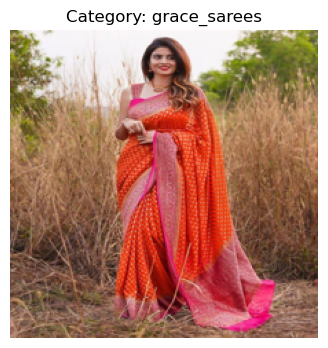

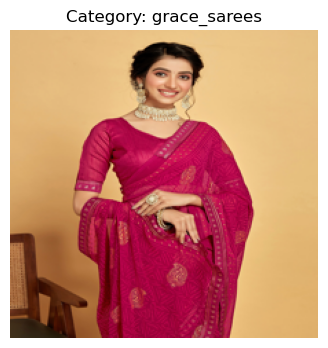

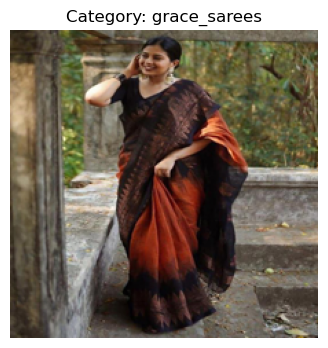

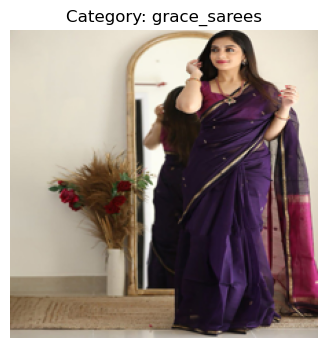

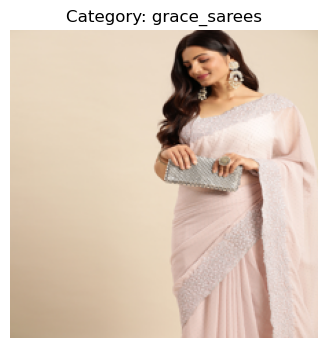

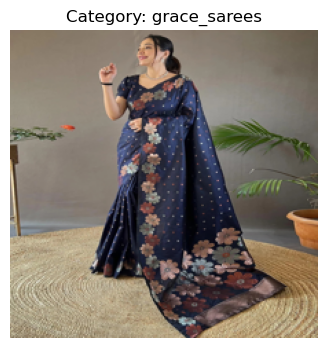

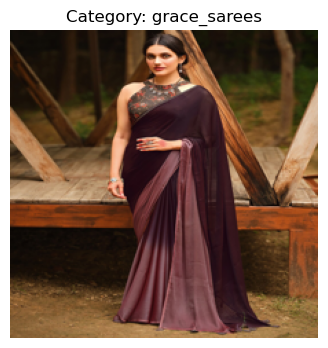

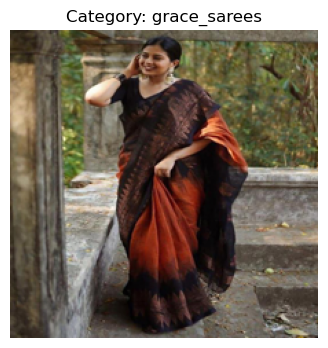

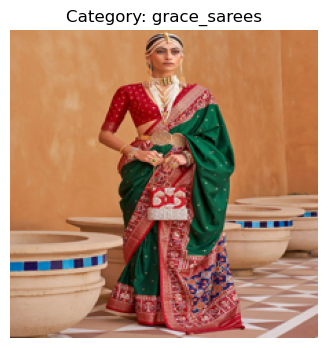

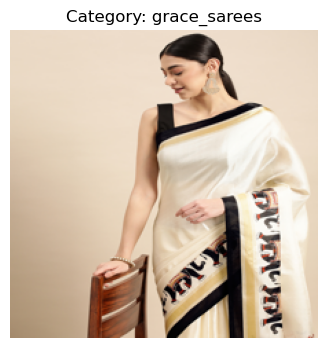

Saved C:\Users\Manya\Desktop\MG\ML\Myntra\categories\collage\public\images\1.jpg
Saved link C:\Users\Manya\Desktop\MG\ML\Myntra\categories\collage\public\links\1.txt
Saved C:\Users\Manya\Desktop\MG\ML\Myntra\categories\collage\public\images\2.jpg
Saved link C:\Users\Manya\Desktop\MG\ML\Myntra\categories\collage\public\links\2.txt
Saved C:\Users\Manya\Desktop\MG\ML\Myntra\categories\collage\public\images\3.jpg
Saved link C:\Users\Manya\Desktop\MG\ML\Myntra\categories\collage\public\links\3.txt
Saved C:\Users\Manya\Desktop\MG\ML\Myntra\categories\collage\public\images\4.jpg
Saved link C:\Users\Manya\Desktop\MG\ML\Myntra\categories\collage\public\links\4.txt
Saved C:\Users\Manya\Desktop\MG\ML\Myntra\categories\collage\public\images\5.jpg
Saved link C:\Users\Manya\Desktop\MG\ML\Myntra\categories\collage\public\links\5.txt
Saved C:\Users\Manya\Desktop\MG\ML\Myntra\categories\collage\public\images\6.jpg
Saved link C:\Users\Manya\Desktop\MG\ML\Myntra\categories\collage\public\links\6.txt
Save

In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import requests
from PIL import Image
from io import BytesIO
import re
import matplotlib.pyplot as plt
import os
import shutil

def fetch_and_preprocess_image(image_url):
    try:
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        img = img.resize((224, 224))
        img_array = np.array(img) / 255.0
        return img, img_array
    except Exception as e:
        print(f"Error fetching or processing image from {image_url}: {e}")
        return None, None

def perform_image_segmentation(image_array, model):
    try:
        image = tf.convert_to_tensor(image_array, dtype=tf.float32)
        image = tf.image.resize(image, [224, 224])
        image = tf.expand_dims(image, 0)
        result = model(image)
        segmented_image = tf.argmax(result, axis=-1)[0].numpy()
        return segmented_image
    except Exception as e:
        print(f"Error performing image segmentation: {e}")
        return None

def preprocess_text_data(text_data, vectorizer):
    X_text_vec = vectorizer.transform(text_data)
    return X_text_vec

def classify_test_data(test_df, svm_classifier, vectorizer, feature_length, model):
    men_keywords = ['men', 'male', 'man', 'gentlemen']
    women_keywords = ['women', 'female', 'woman', 'ladies']
    
    women_categories = [
        'bohemian', 'elegant', 'ethnic', 'kurta_minimalism', 'bold',
        'grace_sarees', 'women_formal'
    ]
    men_categories = [
        'men_formal', 'men_casual', 'men_urban', 'men_festive'
    ]
    
    predicted_categories = []
    images_with_categories = []
    
    for index, row in test_df.iterrows():
        description = row['description']
        image_url = row['img1']
        
        # Use regular expressions to detect whole words for men's and women's keywords
        is_men = any(re.search(rf'\b{keyword}\b', description.lower()) for keyword in men_keywords)
        is_women = any(re.search(rf'\b{keyword}\b', description.lower()) for keyword in women_keywords)
        
        print(f"Processing image at index {index}. Description: {description}")
        print(f"is_men: {is_men}, is_women: {is_women}")
        
        image, image_array = fetch_and_preprocess_image(image_url)
        if image_array is None:
            print(f"Skipping image at index {index} due to previous error.")
            predicted_categories.append('unknown')
            images_with_categories.append((None, 'unknown', description))
            continue
        
        segmented_image = perform_image_segmentation(image_array, model)
        if segmented_image is None:
            print(f"Skipping image at index {index} due to segmentation error.")
            predicted_categories.append('unknown')
            images_with_categories.append((image, 'unknown', description))
            continue
        
        image_features = segmented_image.flatten()
        image_features = image_features[:feature_length]
        image_features = np.pad(image_features, (0, max(0, feature_length - len(image_features))), 'constant')
        
        text_features = preprocess_text_data([description], vectorizer).toarray()
        combined_features = np.concatenate((text_features, image_features.reshape(1, -1)), axis=1)
        
        predicted_category = svm_classifier.predict(combined_features[:, :feature_length])[0]
        
        if is_men and predicted_category not in men_categories:
            # Force reclassification into men categories
            predicted_category = 'men_unknown'  # Placeholder category for men items misclassified
        elif is_women and predicted_category not in women_categories:
            # Force reclassification into women categories
            predicted_category = 'women_unknown'  # Placeholder category for women items misclassified
        
        predicted_categories.append(predicted_category)
        images_with_categories.append((image, predicted_category, description))
        
        print(f"Processed image at index {index}. Predicted category: {predicted_category}")
        print("="*50)
    
    return predicted_categories, images_with_categories

def save_images_to_folder(df, category, folder_path,link_folder_path,categories_path):
    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)
    os.makedirs(link_folder_path, exist_ok=True)
    
    # Filter 8 images from the category with the maximum frequency
    top_category_images = df[df['predicted_category'] == category].head(9)
    
    # Save these images to the specified folder and store product links
    data = []
    for i, (_, row) in enumerate(top_category_images.iterrows()):
        img, _ = fetch_and_preprocess_image(row['img1'])
        if img:
            image_path = os.path.join(folder_path, f"{i + 1}.jpg")
            img.save(image_path)
            print(f"Saved {image_path}")
            
            link_file_path = os.path.join(link_folder_path, f"{i + 1}.txt")
            with open(link_file_path, 'w') as file:
                file.write(row['product_link'])
                print(f"Saved link {link_file_path}")
                
    
    image_path = os.path.join(categories_path, f"{category}.jpg")
    
    # Construct the destination file path
    dest_image_path = os.path.join(folder_path, "10.jpg")
    
    # Copy and rename the file
    shutil.copy(image_path, dest_image_path)
    print(image_path)
    # Save the link to a text file
    link_file_path = os.path.join(folder_path, "10.txt")
    with open(link_file_path, 'w') as file:
        file.write("#")
        print(f"Saved link {link_file_path}")



def main():
    # Load the training data
    df_train = pd.read_csv('training.csv')
    df_train['description'] = df_train['description'].fillna('')
    
    vectorizer = TfidfVectorizer(max_features=1000)
    X_text_train = df_train['description']
    y_train = df_train['category']
    
    X_train_text_vec = vectorizer.fit_transform(X_text_train)
    
    svm_classifier = SVC(kernel='linear')
    svm_classifier.fit(X_train_text_vec, y_train)
    
    feature_length = 1000  # Ensure consistent feature length
    
    # Load the test data
    df_test = pd.read_csv('women_user.csv')
    
    print("Loading MobileNetV2 model from TensorFlow Hub...")
    model = hub.load("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4")
    print("Model loaded successfully.")
    
    print("Classifying test data and displaying images...")
    predicted_categories, images_with_categories = classify_test_data(df_test, svm_classifier, vectorizer, feature_length, model)
    
    df_test['predicted_category'] = predicted_categories
    
    # Calculate the frequency of each category
    category_counts = df_test['predicted_category'].value_counts()
    max_frequency_category = category_counts.idxmax()
    
    print(f"Category with maximum frequency: {max_frequency_category}")
    
    df_classified = pd.read_csv('test_predictions_with_segmentation.csv')

#     top_category_images = df_classified[df_test['predicted_category'] == max_frequency_category].head(15)
    
    # Display these images
    for _, row in top_category_images.iterrows():
        img, _ = fetch_and_preprocess_image(row['img1'])
        if img:
            plt.figure(figsize=(4, 4))
            plt.imshow(img)
            plt.title(f"Category: {max_frequency_category}")
            plt.axis('off')
            plt.show()
            
    # Define the folder path where images will be saved
    folder_path = r"C:\Users\Manya\Desktop\MG\ML\Myntra\categories\collage\public\images"
    link_folder_path = r"C:\Users\Manya\Desktop\MG\ML\Myntra\categories\collage\public\links"
    categories_path = r"C:\Users\Manya\Desktop\MG\ML\Myntra\categories\collage\public\celebs"

    
    # Run the function to save images
    save_images_to_folder(df_classified, max_frequency_category, folder_path,link_folder_path,categories_path)

    
    return top_category_images

# Run the main function
top_category_images = main()


